In [1]:
import numpy as np
import torch
import sys
sys.path.append('../')
from voting_games.werewolf_env_v0 import pare, Roles, Phase
from notebooks.learning_agents.models import ActorCriticAgent
from notebooks.learning_agents.utils import play_static_game, play_recurrent_game
from notebooks.learning_agents.static_agents import (
    random_approval_villager, 
    random_coordinated_approval_villager, 
    random_agent,
    random_approval_wolf,
    revenge_approval_wolf,
    coordinated_revenge_approval_wolf,
    random_likes_approval_wolf,
    aggressive_approval_wolf,
    )
import notebooks.learning_agents.stats as indicators
import random
import copy
from matplotlib import pyplot as plt
from tqdm import tqdm
from tabulate import tabulate

/root/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Approval Voting

Approval voting is a mechanism in which voters can select as many candidates from a list of all possible candidates to approve of. 

## Win Rates

We assume that some of the findings in the plurality werewolf game {cite}`braverman2008mafia` will still hold for approval voting, due to the nature of calculating the consensus amongst all the targetting done. (Target with the most dislikes gets voted out).


```{note}
Below is code to generate the following table of 1000 runs between each villager policy and each werewolf policy. We base our discussion around this markdown table.
```

It is clear given the table below that trained villagers learned how to maneuver using an approval mechanism to their advantage. Even against aggressive wolves, and no game breaking coordination mechanic as in CL-Targets, they were able to score the highest.

CRLWolves were specifically tailored to stump our agents, and seeing that this is the wolf policy they did the poorest does confirm that trained villager agents relied on "likes" and "neutral" feelings of other agents across candidates.

Villager Strategy vs. | [Random](rwolves) | [CRWolves](crwolves) | [RevWolves](revwolves) | [CRevWolves](crevwolves) | [CRLWolves](crlwolves) | [AggroWolves](aggrowolves) |
| --- | --- | --- | --- | --- | --- | --- |
[Random](r-villagers) | 0.599 | 0.065 | 0.118 | 0.137 | 0.085 | 0.002 |
[L-Targets](l-villagers) | 0.676 | 0.12 | 0.243 | 0.209 | 0.122 | 0.023 |
[CL-Targets](cl-villagers) | 0.682 | 0.288 | 0.302 | 0.294 | 0.291 | 0.311 |
[Trained-CRWolves](trained-villagers) | 0.567 | 0.532 | 0.577 | 0.582 | 0.193 | 0.385 |

In [2]:
env = pare(num_agents=10, werewolves=2, num_accusations=2)
observations, _, _, _, _ = env.reset()
obs_size= env.convert_obs(observations['player_0']['observation']).shape[-1]

trained_approval_agent = ActorCriticAgent({"rec_hidden_size": 256,
                                        "rec_layers": 1, 
                                        "joint_mlp_size": 128,
                                        "split_mlp_size": 128,
                                        "num_votes": 10,
                                        "approval_states": 3},
                                        num_players=10,
                                        obs_size=obs_size)
trained_approval_agent.load_state_dict(torch.load("../notebooks/stored_agents/lstm_first_no_one_hot_256_128/approval_agent_10_score_53.pth"))

num_games = 1000
print(f'10 players, with 2 wolves - number of games played : {num_games} \n')

rv_wins = []
rv_replays = []
for wolf_policy in [random_agent, random_approval_wolf, revenge_approval_wolf, coordinated_revenge_approval_wolf, random_likes_approval_wolf, aggressive_approval_wolf]:
    wins, replays = play_static_game(env, wolf_policy, random_agent, num_times=num_games)
    rv_wins.append(wins/float(num_games))
    rv_replays.append(replays)

rav_wins = []
rav_replays = []
for wolf_policy in [random_agent, random_approval_wolf, revenge_approval_wolf, coordinated_revenge_approval_wolf, random_likes_approval_wolf, aggressive_approval_wolf]:
    wins, replays = play_static_game(env, wolf_policy, random_approval_villager, num_times=num_games)
    rav_wins.append(wins/float(num_games))
    rav_replays.append(replays)

cav_wins = []
cav_replays = []
for wolf_policy in [random_agent, random_approval_wolf, revenge_approval_wolf, coordinated_revenge_approval_wolf, random_likes_approval_wolf, aggressive_approval_wolf]:
    wins, replays = play_static_game(env, wolf_policy, random_coordinated_approval_villager, num_times=num_games)
    cav_wins.append(wins/float(num_games))
    cav_replays.append(replays)

tav_wins = []
tav_replays = []
for wolf_policy in [random_agent, random_approval_wolf, revenge_approval_wolf, coordinated_revenge_approval_wolf, random_likes_approval_wolf, aggressive_approval_wolf]:
    wins, replays = play_recurrent_game(env, wolf_policy, trained_approval_agent, num_times=num_games, hidden_state_size=256, voting_type="approval")
    tav_wins.append(wins/float(num_games))
    tav_replays.append(replays)

print(tabulate([['Random', *rv_wins], 
                ['L-Targets', *rav_wins], 
                ['CL-Targets', *cav_wins], 
                ['Trained-CRWolves', *tav_wins]], 
               headers=["Villager Strategy", 
                        "RWolves", 
                        "CRWolves", 
                        "RevWolves",
                        "CRevWolves",
                        "CRLWolves",
                        "AggroWolves"]))

10 players, with 2 wolves - number of games played : 1000 

Villager Strategy      RWolves    CRWolves    RevWolves    CRevWolves    CRLWolves    AggroWolves
-------------------  ---------  ----------  -----------  ------------  -----------  -------------
Random                   0.603       0.062        0.088         0.07         0.086          0.011
L-Targets                0.681       0.119        0.175         0.116        0.116          0.026
CL-Targets               0.674       0.303        0.295         0.283        0.299          0.302
Trained-CRWolves         0.595       0.508        0.578         0.515        0.151          0.381


In [3]:
tav_win_replays = [[r for r in replay if r[-1]["winners"] == Roles.VILLAGER] for replay in tav_replays]
rv_win_replays = [[r for r in replay if r[-1]["winners"] == Roles.VILLAGER] for replay in rv_replays]
rav_win_replays = [[r for r in replay if r[-1]["winners"] == Roles.VILLAGER] for replay in rav_replays]
cav_win_replays = [[r for r in replay if r[-1]["winners"] == Roles.VILLAGER] for replay in cav_replays]

### Days elapsed before a villager win

In [17]:
rv_days = [np.mean([villager_win[-1]["day"] for villager_win in replays]) for replays in rv_win_replays]
rav_days = [np.mean([villager_win[-1]["day"] for villager_win in replays]) for replays in rav_win_replays]
cav_days = [np.mean([villager_win[-1]["day"] for villager_win in replays]) for replays in cav_win_replays]
tav_days = [np.mean([villager_win[-1]["day"] for villager_win in replays]) for replays in tav_win_replays]

print(tabulate([['Random', *rv_days], 
                ['L-Targets', *rav_days], 
                ['CL-Targets', *cav_days], 
                ['Trained-CRWolves', *tav_days]], 
               headers=["Villager Strategy", 
                        "RWolves", 
                        "CRWolves", 
                        "RevWolves",
                        "CRevWolves",
                        "CRLWolves",
                        "AggroWolves"]))

Villager Strategy      RWolves    CRWolves    RevWolves    CRevWolves    CRLWolves    AggroWolves
-------------------  ---------  ----------  -----------  ------------  -----------  -------------
Random                 3.13856     3.52308      3.39831       3.43066      3.37647        2
L-Targets              3.17012     3.53333      3.53086       3.58373      3.46721        3.73913
CL-Targets             3.08504     3.46181      3.49338       3.4898       3.5189         3.47588
Trained-CRWolves       3.16931     3.21805      3.24783       3.26117      3.37306        3.26494


Days elapsed is a good litmus of whether or not a learning agent has learned to coordinate and finish games quicker. We can see that our  trained villagers were faster against CRWolves (which they were trained against), as well as against RevWolves, CRevWolves, CRLWolves, and AggroWolves. Random villagers only won a single game or two aagainst the AggroWolves, making that data point very insignificant.

### Days between wolf executions

In [12]:
# skipping random wolves because they may kill eachother during the night
tav_exec = [np.mean([b-a for a,b in [indicators._when_did_wolves_get_killed(vwin) for vwin in replays]]) for replays in tav_win_replays[1:]]
rv_exec = [np.mean([b-a for a,b in [indicators._when_did_wolves_get_killed(vwin) for vwin in replays]]) for replays in rv_win_replays[1:]]
rav_exec = [np.mean([b-a for a,b in [indicators._when_did_wolves_get_killed(vwin) for vwin in replays]]) for replays in rav_win_replays[1:]]
cav_exec = [np.mean([b-a for a,b in [indicators._when_did_wolves_get_killed(vwin) for vwin in replays]]) for replays in cav_win_replays[1:]]

print(tabulate([['Random', *rv_exec], 
                ['L-Targets', *rav_exec], 
                ['CL-Targets', *cav_exec], 
                ['Trained-CRWolves', *tav_exec]], 
               headers=["Villager Strategy", 
                        "CRWolves", 
                        "RevWolves",
                        "CRevWolves",
                        "CRLWolves",
                        "AggroWolves"]))

Villager Strategy      CRWolves    RevWolves    CRevWolves    CRLWolves    AggroWolves
-------------------  ----------  -----------  ------------  -----------  -------------
Random                  1.64516      1.69318       1.65714      1.61628        1.81818
L-Targets               1.59664      1.66857       1.77586      1.67241        1.73077
CL-Targets              1.69307      1.72881       1.66784      1.60535        1.61921
Trained-CRWolves        1.51378      1.48097       1.4932       1.60265        1.41995


```{warning}
RWolves were skipped simply because they would kill themselves sometimes at night, and this indicator relies on wolves being explicitly executed by villager consensus
```

This is yet another litmus test for coordination and learning, as we expect this number to be lower the more coordinated the trained agents are, and indeed it is. Interestingly, we also see that against AggroWolves, our trained villagers had the lowest values, indicating that the aggressive wolves were executed one after another the most often. This makes sense as aggressive wolves were targetting everyone, and would be the easiest to spot, however our trained agents were not trained against AggroWolves, so this finding promotes the idea that our trained agents generalized to somewhat consistent patterns.


### Ties

When it comes to ties, We can see that against CRWolves, ties in voting phases are lower than in accusation phases. If there was a tie in a prior accusation round, we can see that our trained agents only tie in subsequent voting rounds roughly a third of the time for CRWolves, RevWolves and CRevWolves, while haaving a much higher chance to tie against CRLWolves that have successfully tricked them, and against AggroWolves where there are a lot more targetting votes altogether. 

Sometimes a wolf is one of the targets in a tie, and they may end up getting lucky. Our last column looks at the rates at which this wolf gets targetted in a subsequent voting round, and we can see that it is quite high, especially so for CLRWolves. Although they struggled against CLRWolves, when the trained villagers were sure of a target, they did not take any chances after a tie. 


In [32]:
tie_info = [np.nanmean(np.stack([indicators._process_tie_info(indicators._game_tie_info(replay, voting_type="approval")) for replay in replays]), axis=0) for replays in tav_win_replays[1:]]
print(tabulate([['vs. CRWolves', *tie_info[0]], 
                ['vs. RevWolves', *tie_info[1]], 
                ['vs. CRevWolves', *tie_info[2]], 
                ['vs. CRLWolves', *tie_info[3]],
                ['vs. AggroWolves', *tie_info[4]]], 
               headers=["Trained-CRWolves", 
                        "Tie in Accusation", 
                        "Tie in Voting",
                        "Tie in Voting given a  tie in accusation",
                        "Likelihood of wolf targetted after a tie"]))

Trained-CRWolves      Tie in Accusation    Tie in Voting    Tie in Voting given a  tie in accusation    Likelihood of wolf targetted after a tie
------------------  -------------------  ---------------  ------------------------------------------  ------------------------------------------
vs. CRWolves                   0.361959         0.330545                                    0.330735                                    0.649485
vs. RevWolvess                 0.383506         0.308968                                    0.303485                                    0.615789
vs. CRevWolves                 0.367476         0.315696                                    0.316737                                    0.52439
vs. CRLWolves                  0.35734          0.41777                                     0.420775                                    0.764706
vs. AggroWolves                0.394466         0.385389                                    0.406364                               

### Targetting Indicators

Our indicators are averaged out and stacked across phases and days, and as a reminder, here they are

- average target count (0)
- average like count (1)
- average neutral count (2)
- average self target (3)
- average self like (4)
- percentage of wolves in top targets (5)
- percentage of wolves in top likes (6)
- percent of votes targetting dead players (7)
- percent of votes targetting wolves by tracking:
    - percent of votes targetting dead wolves (8)
    - percent of votes targetting wolves that are still alive (9)
- percent of likes towards wolves by tracking:
    - percent of likes for dead wolves (10)
    - percent of likes for wolves that are still alive (11)
- percent of likes towards villagers by tracking:
    - percent of likes towards dead villagers (12)
    - perceent of likes towards villagers that are still alive (13)

In [33]:
tav_avg_records = [indicators._game_avg_records(replays, indicators._approval_target_indicators) for replays in tav_win_replays]
tav_stacked = [np.stack(list(avg_records.values())) for avg_records in tav_avg_records]

rv_avg_records = [indicators._game_avg_records(replays, indicators._approval_target_indicators) for replays in rv_win_replays]
rv_stacked = [np.stack(list(avg_records.values())) for avg_records in rv_avg_records]

In [34]:
print(tav_stacked[1].shape)

(4, 3, 14)


[[0.         0.         0.        ]
 [0.04624109 0.04645411 0.04286884]
 [0.0816879  0.07923769 0.07022729]
 [0.0957539  0.09839249 0.0852545 ]]


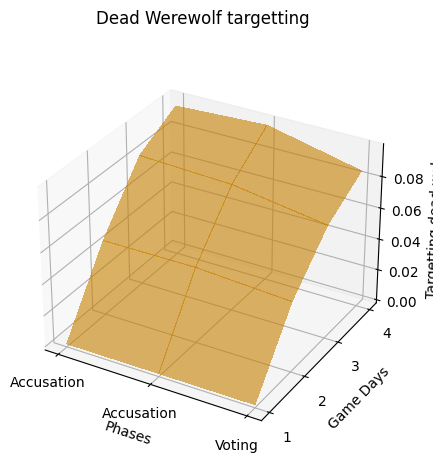

In [36]:
print(tav_stacked[0][:,:,8])

t = [0,1,2,3]
x = [0,1,2]

xx, yy = np.meshgrid(x,t)
plt.style.use('default')

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.set_ylabel("Game Days")
ax.set_yticks([0,1,2,3], ['1','2','3','4'])
ax.set_xlabel("Phases")
x_tick_labels = ["Accusation", "Accusation", "Voting"]
ax.set_xticks([0,1,2], x_tick_labels)
ax.set_zlabel("Targetting dead wolves")
surf = ax.plot_surface(xx,yy,tav_stacked[0][:,:,8], color="orange", alpha=0.6, antialiased=False)
plt.suptitle("Dead Werewolf targetting")
plt.show()

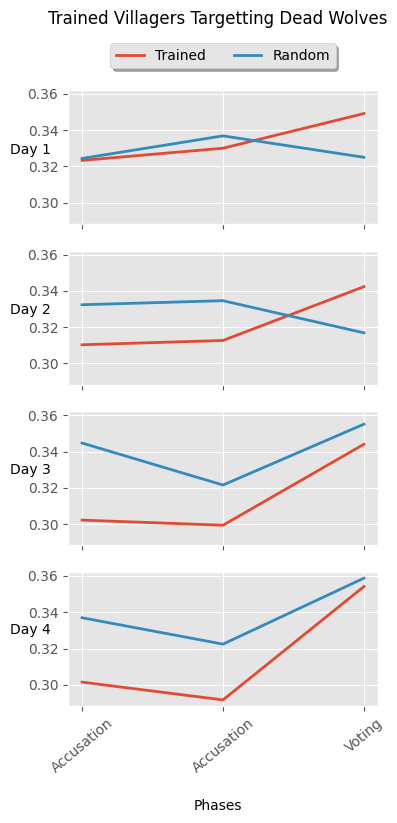

In [59]:
plt.style.use('ggplot')

# make data
x = [1,2,3]
#y = tpv_stacked[:,:,0][3]

# plot
fig, axs = plt.subplots(4, 1, figsize=(4,8), sharex=True, sharey=True)

for day in range(tav_stacked[0].shape[0]):
    #for phase in range(tav_stacked[0].shape[1]):
    axs[day].plot(list(range(tav_stacked[0].shape[1])), tav_stacked[0][:,:,4][day], linewidth=2.0, label="Trained")
    axs[day].plot(list(range(rv_stacked[0].shape[1])), rv_stacked[0][:,:,4][day], linewidth=2.0, label="Random")

# set 
x_tick_labels = ["Accusation", "Accusation", "Voting"]
axs[3].set_xticks([0,1,2], x_tick_labels, rotation=40)

axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.40),
          ncol=3, fancybox=True, shadow=True)

fig.suptitle("Trained Villagers Targetting Dead Wolves")

fig.text(0.5, -0.02, 'Phases', ha='center')
# fig.text(0.04, 0.5, 'Days', va='center', rotation='vertical')

fig.text(-0.02, 0.80, 'Day 1')
fig.text(-0.02, 0.60, 'Day 2')
fig.text(-0.02, 0.40, 'Day 3')
fig.text(-0.02, 0.20, 'Day 4')
plt.show()

Text(-0.02, 0.2, 'Day 4')

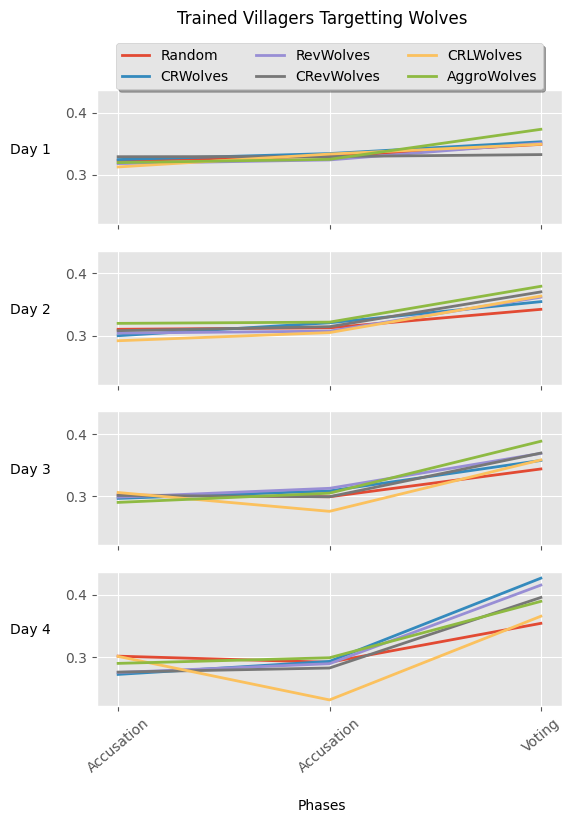

In [61]:
plt.style.use('ggplot')

# make data
x = [1,2,3]
#y = tpv_stacked[:,:,0][3]

# plot
fig, axs = plt.subplots(4, 1, figsize=(6,8), sharex=True, sharey=True)

for day in range(tav_stacked[0].shape[0]):
    for name, stacked in zip(["Random", "CRWolves", "RevWolves", "CRevWolves", "CRLWolves", "AggroWolves"], tav_stacked):
        axs[day].plot(list(range(stacked.shape[1])), stacked[:,:,4][day], linewidth=2.0, label=name)

# set 
x_tick_labels = ["Accusation", "Accusation", "Voting"]
axs[3].set_xticks([0,1,2], x_tick_labels, rotation=40)

axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.40),
          ncol=3, fancybox=True, shadow=True)

fig.suptitle("Trained Villagers Targetting Wolves")

fig.text(0.5, -0.02, 'Phases', ha='center')
# fig.text(0.04, 0.5, 'Days', va='center', rotation='vertical')

fig.text(-0.02, 0.80, 'Day 1')
fig.text(-0.02, 0.60, 'Day 2')
fig.text(-0.02, 0.40, 'Day 3')
fig.text(-0.02, 0.20, 'Day 4')


Harder to tell what is happening given these indicators, but we can assume given the win rates and tie rates that targets and likes are flying around, yet the main targets are still the wolves.

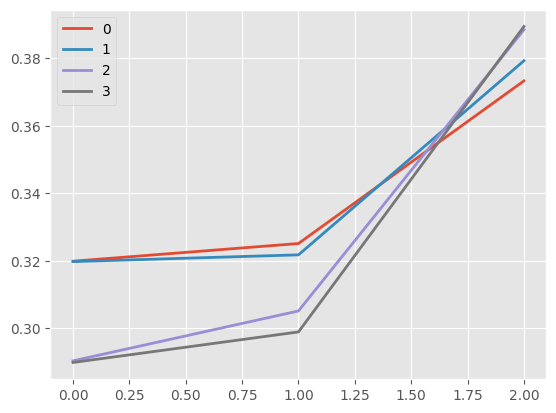

In [69]:
# TODO : Graph one stat across days on the same plot

fig = plt.figure()

for day in range(tav_stacked[0].shape[0]):
    plt.plot(list(range(stacked.shape[1])), stacked[:,:,4][day], linewidth=2.0, label=day)

plt.legend()

# plt.plot([1,2,3], [1,2,3])